In [324]:
import params as par
import background as bg
from background import τ_now, τ_rec

from scipy import integrate
from scipy.interpolate import interp1d
from scipy.special import spherical_jn
import numpy as np
import matplotlib.pyplot as plt
import copy
import pickle
import matplotlib as mpl
import numba

In [325]:
# Plot Settings
plt.rcParams.update(par.plot_params)

# k and τ arrays
k_solve = np.linspace(par.k_low, par.k_high, par.K_SOLVE)
k_int = np.linspace(par.k_low, par.k_high, par.K_INT)
τ_solve = pickle.load(open( "data/tau_solve.p", "rb" ) )

# Load mode functions
δd = pickle.load(open( "data/delta_d.p", "rb" ) )
vd = pickle.load(open( "data/v_d.p", "rb" ) )
δɣ = pickle.load(open( "data/delta_g.p", "rb" ) )
vɣ = pickle.load(open( "data/v_g.p", "rb" ) )
Φ = pickle.load(open( "data/phi.p", "rb" ) )

# Load gdm functions
wd_F = pickle.load(open( "data/w_d.p", "rb" ) )
Dwd_F = pickle.load(open( "data/Dw_d.p", "rb" ) )
cs2d_F = pickle.load(open( "data/cs2_d.p", "rb" ) )



In [326]:
# evalate everything at the τ_solve


ℋ = bg.ℋ(τ_solve)
a =  bg.a(τ_solve)
yb = bg.yb(τ_solve)

Ωb = bg.Ωb(τ_solve)
Ωɣ = bg.Ωɣ(τ_solve)
Ωd = bg.Ωd(τ_solve)

In [327]:
# Get initial conditions:

δd0=δd[:,0]
vd0=vd[:,0]
δɣ0=δɣ[:,0]
vɣ0=vɣ[:,0]
Φ0= Φ[:,0]

In [328]:
from params import *
#ℋ = lambda τ: 2*α*(α*τ/τr + 1)/(α**2 * (τ**2/τr) + 2*α*τ)
τs = 0.6*Ωm0**(.25) * Ωb0**(-.5)*a_rec**(.75)*(H0/100)**(-.5)*τr

In [329]:
"""Precompute Bessel Functions"""

l_list = np.array([i for i in range(2,50,1)]+[i for i in range(50,200,5)] + 
     [i for i in range(200, 1200, 20)])

Cl = np.zeros(len(l_list))

k_list2  = np.linspace(par.k_low, par.k_high, par.K_INT)

JLK = np.array([
    spherical_jn(l, k_list2*(bg.τ_now-bg.τ_rec))
                for l in l_list])
DJLK = np.array([
    spherical_jn(l, k_list2*(bg.τ_now-bg.τ_rec), derivative=True) 
    for l in l_list])

In [330]:
wd = wd_F
Dwd = Dwd_F
cs2d = cs2d_F

Y0 = np.zeros((5,par.K_SOLVE))
#@numba.jit(nopython=True)
def DY(i, τ, Y):
        dY = np.zeros((5,K_SOLVE))
        Φ = Y[0,:]
        δɣ = Y[1,:]
        vɣ = Y[2,:]
        δd = Y[3,:]
        vd = Y[4,:]

           
        #compute background quantities
        ℋi = 2*α*(α*τ/τr + 1)/(α**2 * (τ**2/τr) + 2*α*τ)
        ai =  a_eq*((α*τ/τr)**2 + 2*α*τ/τr)
        ybi = 1.68*ai*Ωb0/Ωr0

        Ωbi = Ωb0 * ai**-3.
        Ωɣi = Ωɣ0 * ai**-4.
        Ωdi = Ωc0 * ai**-3. + Ων0 * ai**-4.

        wdi = np.interp(τ, τ_solve, wd_F)
        Dwdi = np.interp(τ, τ_solve, Dwd_F)
        
        #interpolate cs2
        idx = np.searchsorted(τ_solve, τ) - 1
        d = (τ - τ_solve[idx]) / (τ_solve[idx + 1] - τ_solve[idx])
        cs2di = (1 - d) * cs2d[:,idx]   + cs2d[:,idx + 1] * d

        wdi = wd_F_(τ)
        Dwdi = Dwd_F_(τ)
        cs2di = cs2d_F_(τ)
        
        
        
        f = vd*Ωdi*(1+wdi) + 4./3.*Ωɣi*vɣ +  Ωbi*vɣ
        #DΦ
        dY[0,:]  = -ℋi*Φ + (3/2.*H0**2.*ai**2/k_solve)*f
        #Dδɣ
        dY[1,:] = -4./3.*k_solve*vɣ + 4*dY[0,:]
        #Dvɣ
        dY[2,:] = (-ℋi*ybi*vɣ + k_solve*δɣ/3)/(
            4./3. + ybi) + k_solve*Φ
        #Dδd
        dY[3,:] = -(1+wdi)*(k_solve*vd-3*dY[0,:]) -\
            3*ℋi*(cs2di-wdi)*δd
        # Dvd
        dY[4,:] = -ℋi*(1-3*wdi)*vd - vd*Dwdi/(1+wdi) +\
            k_solve*δd*cs2di/(1+wdi) + k_solve*Φ

        #return np.array([DΦ, Dδɣ, Dvɣ, Dδd, Dvd])
        return dY

Y0 = np.array([Φ0, δɣ0, vɣ0, δd0, vd0])

In [331]:
stepsizes = np.diff(τ_solve)

#@numba.jit(nopython=True)
def solve(): 
    Y = np.zeros((len(τ_solve), 5, par.K_SOLVE))
    Y[0,:,:] = Y0
    for i, τi in enumerate(τ_solve[:-1]):
        #implement rK4:
        ss = stepsizes[i]
        k1 = ss*DY(i, τi,Y[i,:,:])
        k2 = ss*DY(i, τi+ss/2,Y[i,:,:]+k1/2)
        k3 = ss*DY(i, τi+ss/2,Y[i,:,:]+k2/2)
        k4 = ss*DY(i, τi+ss,Y[i,:,:]+k3)
        
        Y[i+1,:,:] = Y[i,:,:] + k1/6 + k2/3 + k3/3 + k4/6
    return Y
Yf = solve()

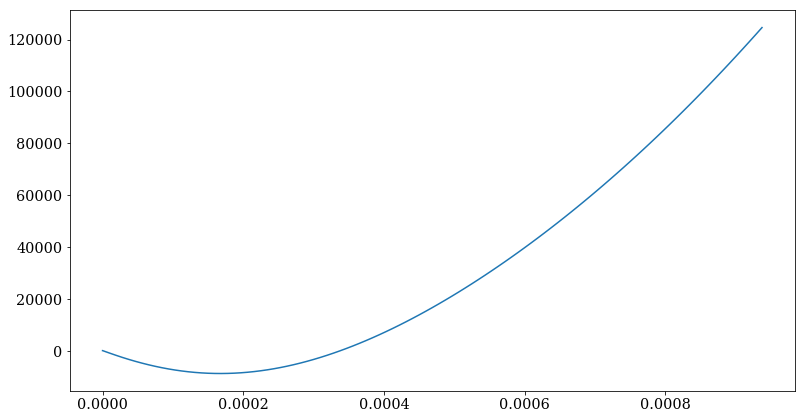

In [332]:
#%timeit Yf = solve()
plt.plot(τ_solve,Yf[:,3,10])

In [333]:
k_grid = np.broadcast_to(k_list2,(L,K_INT))
#@numba.jit(nopython=True)
def get_Cl():
    # first compute mode evolution:
    Yf = solve()[-1,:,:]
    SW = Yf[0,:] + Yf[1,:]/4
    DOP = Yf[2,:]
    SWsd = SW*np.exp(-(k_solve*τs)**2)
    DOPsd = DOP*np.exp(-(k_solve*τs)**2)
    
    # get the power spectrum
    SWfill = np.interp(k_list2, k_solve, SW)
    DOPfill = np.interp(k_list2, k_solve, DOP)
    Dl = SWfill*JLK + DOPfill*(DJLK-JLK/(2*k_list2*(τ_now-τ_rec)))

    T = np.exp(-2*(k_list2*τs)**2 - (.03*k_list2*τ_rec)**2)
    Cl_itgd = Dl**2 *T /k_list2
    Cl = integrate.trapz(k_grid, Cl_itgd)
    Cl_out = l_list*(l_list + 1)*Cl
    return -Cl_out

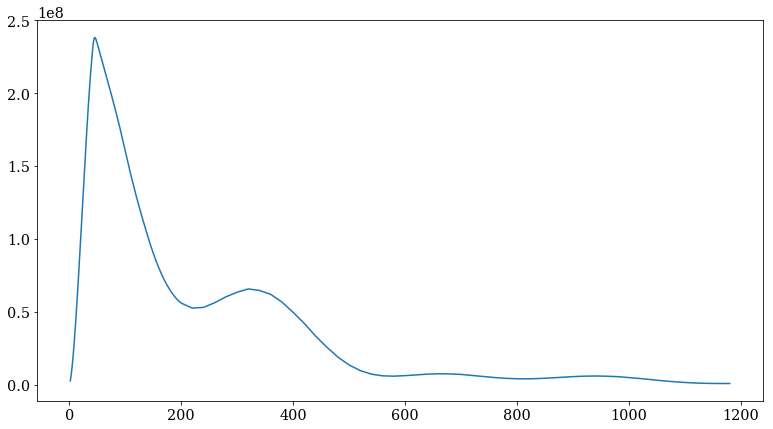

In [334]:
Cl = get_Cl()
plt.plot(l_list,Cl)

In [335]:
# set the w basis
B = np.eye(N)
for n in range(N//2):
    s_n = np.sin((n+1)*np.pi*τ/τ[-1])
    c_n = np.cos(n*np.pi*τ/τ[-1])
    B[:,2*n] = s_n
    B[:,2*n+1] = c_n
#plt.imshow(B)

NameError: name 'τ' is not defined

In [ ]:

# get fiducial power spectrum
wd = copy.deepcopy(wd_F)
cs2d = copy.deepcopy(cs2d_F)

Dwd = np.gradient(wd,τ)
wd_ = interp1d(τ,wd, fill_value="extrapolate")
Dwd_ = interp1d(τ,Dwd, fill_value="extrapolate")
cs2d_ = interp1d(τ,cs2d, fill_value="extrapolate")

Cl_F = get_Cl()

#perturb GDM functions
Θw = np.zeros(N)
Θcs2 = np.zeros((N,K))

Θw[3]=.0001
Θw[1]=.0001
wd = wd_F + B@Θw
cs2d = cs2d_F + Θcs2

Dwd = np.gradient(wd,τ)
wd_ = interp1d(τ,wd, fill_value="extrapolate")
Dwd_ = interp1d(τ,Dwd, fill_value="extrapolate")
cs2d_ = interp1d(τ,cs2d, fill_value="extrapolate")

Cl_per = get_Cl()

In [ ]:
plt.plot(τ, wd_F)
plt.plot(τ, wd, linestyle=':', linewidth=3)
plt.legend(['fiducial w', 'perturbed w'])
plt.show()

plt.plot(τ, wd_F-wd)
plt.legend(['perturbation'])
plt.show()

plt.semilogx(l_list, Cl_F)
plt.plot(l_list, Cl_per)
plt.legend(['fiducial w Cl', 'perturbed w Cl'])
plt.show()